# Grid-Search Preprocessing Steps and Model Parameters

Using pipelines, we can encapsulate all the processing steps in our machine learning workflow in a single scikit-learn estimator.  Another benefit of doing this is that we can now adjust the parameters of the preprocessing using the outcome of a supervised task like regression or classification. In previous chapters, we used polynomial features on the boston dataset before applying the ridge regressor. Let’s model that using a pipeline instead. The pipeline contains three steps—scaling the data, computing polynomial features, and ridge regression:


In [18]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

boston=load_boston()

#split the dataset
X_train,X_test,y_train,y_test=train_test_split(boston.data,boston.target,random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe=make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

How do we know which degrees of polynomials to choose, or whether to choose any polynomials or interactions at all? Ideally we want to select the degree parameter based on the outcome of the classification. Using our pipeline, we can search over the degree parameter together with the parameter alpha of Ridge. To do this, we define a param_grid that contains both, appropriately prefixed by the step names:


In [19]:
param_grid={'polynomialfeatures__degree':[1,2,3],
           'ridge__alpha':[0.001,0.01,0.1,1,10,100]}

#Now we can run our grid search again

grid=GridSearchCV(pipe,param_grid,cv=5,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

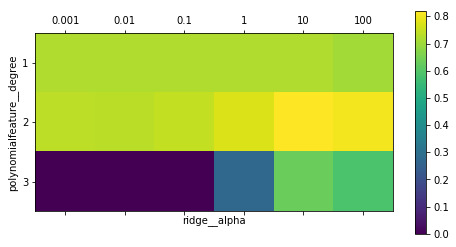

In [20]:
# We can visualize the outcome of the cross-validation using a heat map

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),vmin=0, cmap="viridis") 
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeature__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha']) 
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])

plt.colorbar()

 Heat map of mean cross-validation score as a function of the degree of the polynomial features and alpha parameter of Ridge

Looking at the results produced by the cross-validation, we can see that using polynomials of degree two helps, but that degree-three polynomials are much worse than either degree one or two. This is reflected in the best parameters that were found:


In [21]:
print("Best parameter: {}".format(grid.best_params_))

Best parameter: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [22]:
# which lead to following score
print("Test-set score: {:.2f}".format(grid.score(X_test,y_test)))

Test-set score: 0.77


In [24]:
# Let's run a grid search without polynomial feature for comparision

param_grid={'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
pipe=make_pipeline(StandardScaler(),Ridge())
grid=GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test,y_test)))

Score without poly features: 0.63


As we would expect looking at the grid search results visualized in Figure 6-4, using no polynomial features leads to decidedly worse results. 

Searching over preprocessing parameters together with model parameters is a very powerful strategy. However, keep in mind that GridSearchCV tries all possible combinations of the specified parameters. Therefore, adding more parameters to your grid exponentially increases the number of models that need to be built. 

# Grid-Searching which model to use

You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForest Classifier and an SVC on the iris dataset. We know that the SVC might need the data to be scaled, so we also search over whether to use StandardScaler or no preprocessing. For the RandomForestClassifier, we know that no preprocessing is necessary. We start by defining the pipeline. Here, we explicitly name the steps. We want two steps, one for the preprocessing and then a classifier. We can instantiate this using SVC and StandardScaler:


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipe=Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())])

Now we can define the parameter_grid to search over. We want the classifier to be either RandomForestClassifier or SVC. Because they have different parameters to tune, and need different preprocessing, we can make use of the list of search grids we discussed in “Search over spaces that are not grids”. To assign an estimator to a step, we use the name of the step as the parameter name. When we wanted to skip a step in the pipeline (for example, because we don’t need preprocessing for the RandomForest), we can set that step to None:


In [32]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [ 
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100], 
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}, 
    {'classifier': [RandomForestClassifier(n_estimators=100)], 
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]


In [33]:
from sklearn.datasets import load_breast_cancer
cancer=load_breast_cancer()

# Now, we can instantiate and run the grid search as usual, here on the cancer dataset

X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)

grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classifier': [SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)], 'preprocessing': [StandardScaler(copy=True, with...=0,
            warm_start=False)], 'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-calidation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test,y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-calidation score: 0.99
Test-set score: 0.98


# Summary and Outlook

In this chapter we introduced the Pipeline class, a general-purpose tool to chain together multiple processing steps in a machine learning workflow. Real-world applications of machine learning rarely involve an isolated use of a model, and instead are a sequence of processing steps. Using pipelines allows us to encapsulate multiple steps into a single Python object that adheres to the familiar scikit-learn interface of fit, predict, and transform. In particular when doing model evaluation using crossvalidation and parameter selection using grid search, using the Pipeline class to capture all the processing steps is essential for proper evaluation. The Pipeline class also allows writing more succinct code, and reduces the likelihood of mistakes that can happen when building processing chains without the pipeline class (like forgetting to apply all transformers on the test set, or not applying them in the right order). Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art, and often requires some trial and error. However, using pipelines, this “trying out” of many different processing steps is quite simple. When experimenting, be careful not to overcomplicate your processes, and make sure to evaluate whether every component you are including in your model is necessary. 

